<a href="https://colab.research.google.com/github/HopeRetina/btc_forecasting_LSTM/blob/main/Bitcoin_price_prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In this project, I performed a time series prediction using a Recurrent Neural Network regressor. 

##The particular network architecture I employed for my RNN is a  [**Long Term Short Memory (LTSM)]**, which helps significantly avoid technical problems with optimization of RNNs. 

##Additionally, I compared the performance between normal LSTM, bidirectional LSTM, and convolutional LSTM. 

Data is frome Kaggle [bitcoin history dataset](https://www.kaggle.com/datasets/prasoonkottarathil/btcinusd)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/data_collection/

/content/drive/MyDrive/data_collection


In [4]:
# Load the dataset
df = pd.read_csv('BTC_hourly.csv')

df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,1646089200,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,1646085600,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,1646082000,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,1646078400,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


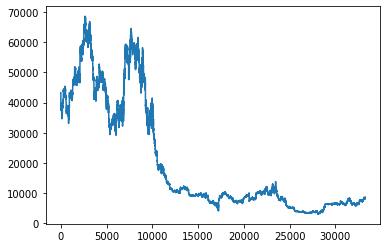

In [5]:
plt.plot(df['close'])
plt.show()

In [6]:
# Convert the df to a numpy array
btc = df[['close']].to_numpy()
btc = btc.astype('float32') #Convert values to float

In [7]:
btc.shape

(33259, 1)

In [8]:
# hope try wrong way
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
btc = scaler.fit_transform(btc)

In [9]:
#We cannot use random way of splitting btc into train and test as
#the sequence of events is important for time series.
#So let us take first 70% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(btc) * 0.7)
test_size = len(btc) - train_size
train, test = btc[0:train_size,:], btc[train_size:len(btc),:]

In [10]:
len(train)

23281

In [11]:
# Here use a UDF to make sequences

# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) and Y is the number of passengers at the next time (t + 1).
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

In [41]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))


Shape of training set: (23270, 10)
Shape of test set: (9967, 10)


##Try a normal LSTM wiht a single LSTM layer

---



In [18]:
# Reshape input to be [samples, time steps, features]
trainX_LSTM = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX_LSTM = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("Shape of training set: {}".format(trainX_LSTM.shape))
print("Shape of test set: {}".format(testX_LSTM.shape))
#
print('Single LSTM with hidden Dense...')
model_LSTM = Sequential()
model_LSTM.add(LSTM(64, input_shape=(None, seq_size)))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(32))
model_LSTM.add(Dense(1))
model_LSTM.compile(loss='mean_squared_error', optimizer='adam')
##monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
##                        verbose=1, mode='auto', restore_best_weights=True)
model_LSTM.summary()
print('Train...')

Shape of training set: (23270, 1, 10)
Shape of test set: (9967, 1, 10)
Single LSTM with hidden Dense...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                19200     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________
Train...


##Bidirectional LSTM

---



In [31]:
trainX_biLSTM = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX_biLSTM = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

from keras.layers import Bidirectional
model_biLSTM = Sequential()
model_biLSTM.add(Bidirectional(LSTM(64, activation='relu'), input_shape=(None, seq_size)))
model_biLSTM.add(Dropout(0.2))
model_biLSTM.add(Dense(32))
model_biLSTM.add(Dense(1))
model_biLSTM.compile(optimizer='adam', loss='mean_squared_error')
model_biLSTM.summary()
print('Train...')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 128)              38400     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 42,561
Trainable params: 42,561
Non-trainable params: 0
_________________________________________________________________
Train...


##Convolutional LSTM (ConvLSTM)

In [42]:
#The layer expects input as a sequence of two-dimensional images, 
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

trainX_convLSTM = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX_convLSTM = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model_convLSTM = Sequential()
model_convLSTM.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model_convLSTM.add(Flatten())
model_convLSTM.add(Dense(32))
model_convLSTM.add(Dense(1))
model_convLSTM.compile(optimizer='adam', loss='mean_squared_error')
model_convLSTM.summary()
#print('Train...')


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          19200     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


##Train

In [ ]:
history_LSTM = model_LSTM.fit(trainX_LSTM, trainY, validation_data=(testX_LSTM, testY),
          verbose=2, epochs=100)

In [20]:
# make predictions

trainPredict = model_LSTM.predict(trainX_LSTM)
testPredict = model_LSTM.predict(testX_LSTM)

In [21]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [22]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 366.11 RMSE
Test Score: 364.80 RMSE


In [23]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(btc)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

In [24]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(btc)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(btc)-1, :] = testPredict

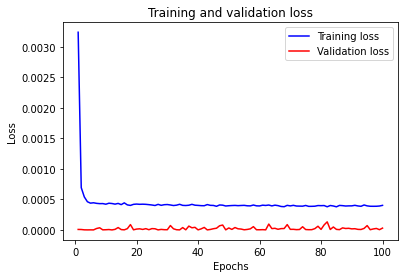

In [25]:
#plot the training and validation accuracy and loss at each epoch
loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Train bidirectional LSTM

---



In [32]:
history_biLSTM = model_biLSTM.fit(trainX_biLSTM, trainY, validation_data=(testX_biLSTM, testY),
          verbose=2, epochs=100)

Epoch 1/100
728/728 - 5s - loss: 0.0043 - val_loss: 9.3205e-04 - 5s/epoch - 7ms/step
Epoch 2/100
728/728 - 4s - loss: 0.0011 - val_loss: 9.8950e-05 - 4s/epoch - 5ms/step
Epoch 3/100
728/728 - 3s - loss: 9.8046e-04 - val_loss: 4.6245e-05 - 3s/epoch - 4ms/step
Epoch 4/100
728/728 - 2s - loss: 0.0010 - val_loss: 6.8701e-06 - 2s/epoch - 3ms/step
Epoch 5/100
728/728 - 2s - loss: 0.0011 - val_loss: 3.0197e-06 - 2s/epoch - 3ms/step
Epoch 6/100
728/728 - 2s - loss: 0.0011 - val_loss: 2.2172e-05 - 2s/epoch - 3ms/step
Epoch 7/100
728/728 - 4s - loss: 0.0010 - val_loss: 4.2440e-05 - 4s/epoch - 5ms/step
Epoch 8/100
728/728 - 3s - loss: 0.0010 - val_loss: 2.1132e-04 - 3s/epoch - 4ms/step
Epoch 9/100
728/728 - 5s - loss: 0.0010 - val_loss: 2.7977e-05 - 5s/epoch - 7ms/step
Epoch 10/100
728/728 - 5s - loss: 0.0010 - val_loss: 2.3366e-05 - 5s/epoch - 7ms/step
Epoch 11/100
728/728 - 4s - loss: 0.0010 - val_loss: 1.2649e-04 - 4s/epoch - 5ms/step
Epoch 12/100
728/728 - 2s - loss: 0.0011 - val_loss: 3.9048

In [33]:
# Predict

trainPredict = model_biLSTM.predict(trainX_biLSTM)
testPredict = model_biLSTM.predict(testX_biLSTM)

In [34]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [35]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 346.65 RMSE
Test Score: 363.33 RMSE


In [36]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(btc)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

In [37]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(btc)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(btc)-1, :] = testPredict

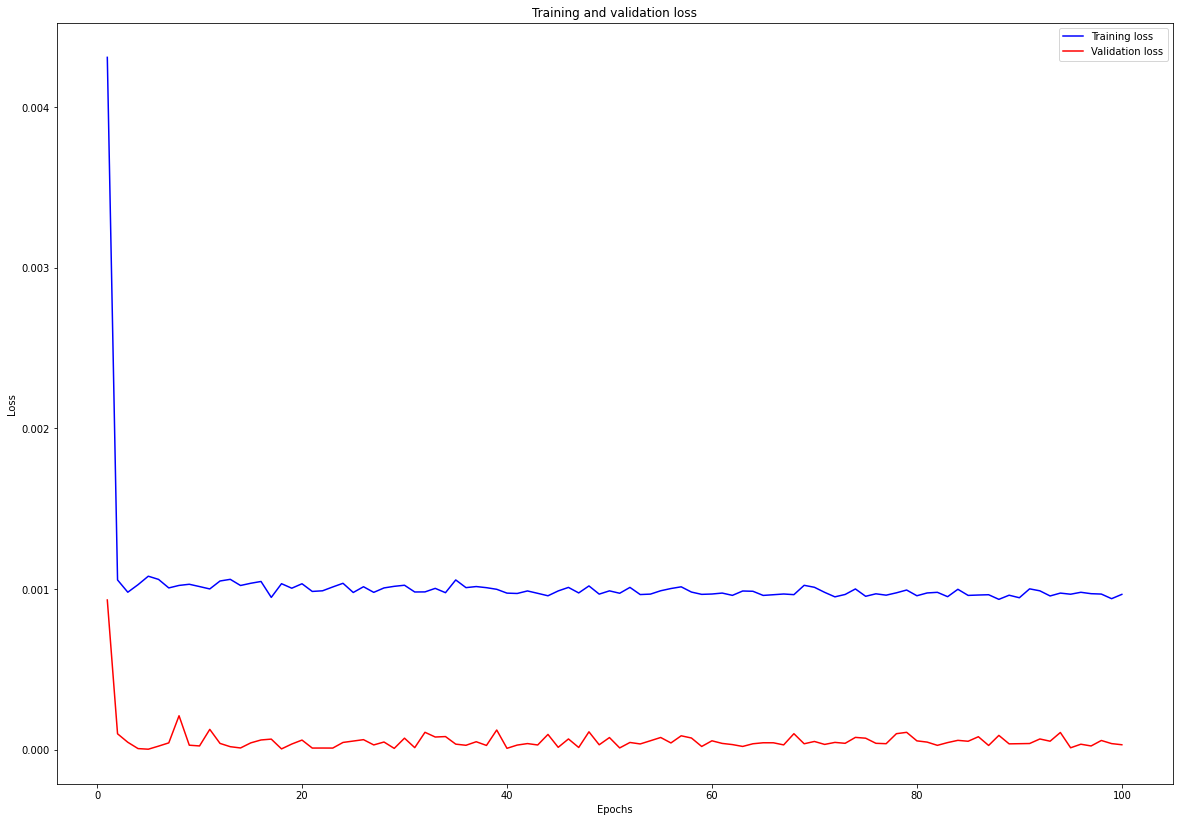

In [39]:
#plot the training and validation accuracy and loss at each epoch
loss = history_biLSTM.history['loss']
val_loss = history_biLSTM.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

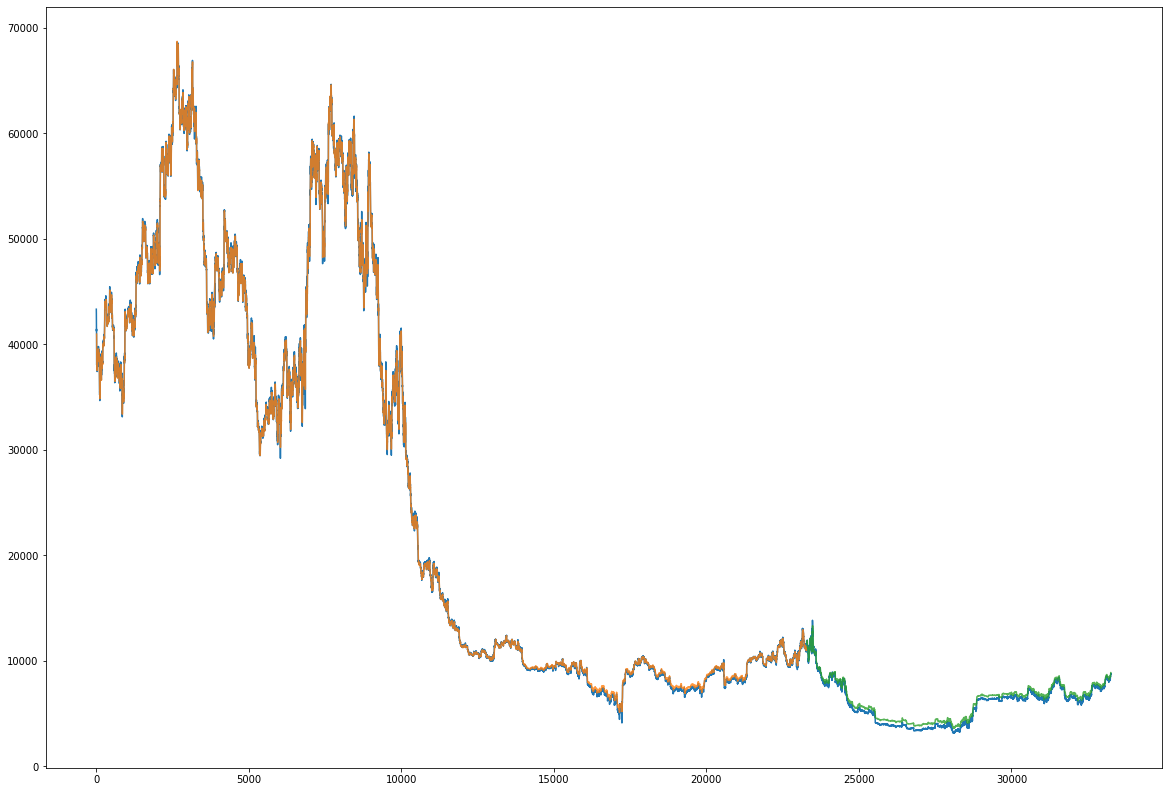

In [40]:
# plot baseline and predictions
plt.rcParams["figure.figsize"] = (20,14)
plt.plot(scaler.inverse_transform(btc))
plt.plot(trainPredictPlot, alpha = 0.8)
plt.plot(testPredictPlot, alpha = 0.8)
plt.show()

##Train convolutional LSTM

---



In [43]:
history_convLSTM = model_convLSTM.fit(trainX_convLSTM, trainY, validation_data=(testX_convLSTM, testY),
          verbose=2, epochs=100)

Epoch 1/100
728/728 - 6s - loss: 0.0041 - val_loss: 7.4570e-06 - 6s/epoch - 9ms/step
Epoch 2/100
728/728 - 3s - loss: 6.2500e-05 - val_loss: 3.0562e-05 - 3s/epoch - 4ms/step
Epoch 3/100
728/728 - 2s - loss: 5.8990e-05 - val_loss: 5.2831e-06 - 2s/epoch - 3ms/step
Epoch 4/100
728/728 - 3s - loss: 5.5080e-05 - val_loss: 5.8443e-06 - 3s/epoch - 4ms/step
Epoch 5/100
728/728 - 2s - loss: 5.0269e-05 - val_loss: 1.3985e-05 - 2s/epoch - 3ms/step
Epoch 6/100
728/728 - 4s - loss: 4.4951e-05 - val_loss: 2.1286e-05 - 4s/epoch - 5ms/step
Epoch 7/100
728/728 - 4s - loss: 3.7964e-05 - val_loss: 1.5974e-05 - 4s/epoch - 5ms/step
Epoch 8/100
728/728 - 2s - loss: 3.6623e-05 - val_loss: 1.3549e-05 - 2s/epoch - 3ms/step
Epoch 9/100
728/728 - 3s - loss: 3.7354e-05 - val_loss: 1.5079e-05 - 3s/epoch - 5ms/step
Epoch 10/100
728/728 - 5s - loss: 3.5351e-05 - val_loss: 3.0963e-05 - 5s/epoch - 6ms/step
Epoch 11/100
728/728 - 4s - loss: 3.2360e-05 - val_loss: 1.4108e-05 - 4s/epoch - 5ms/step
Epoch 12/100
728/728 - 

In [44]:
# Predicti

trainPredict = model_convLSTM.predict(trainX_convLSTM)
testPredict = model_convLSTM.predict(testX_convLSTM)

In [45]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [46]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 276.36 RMSE
Test Score: 634.12 RMSE


In [47]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(btc)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

In [48]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(btc)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(btc)-1, :] = testPredict

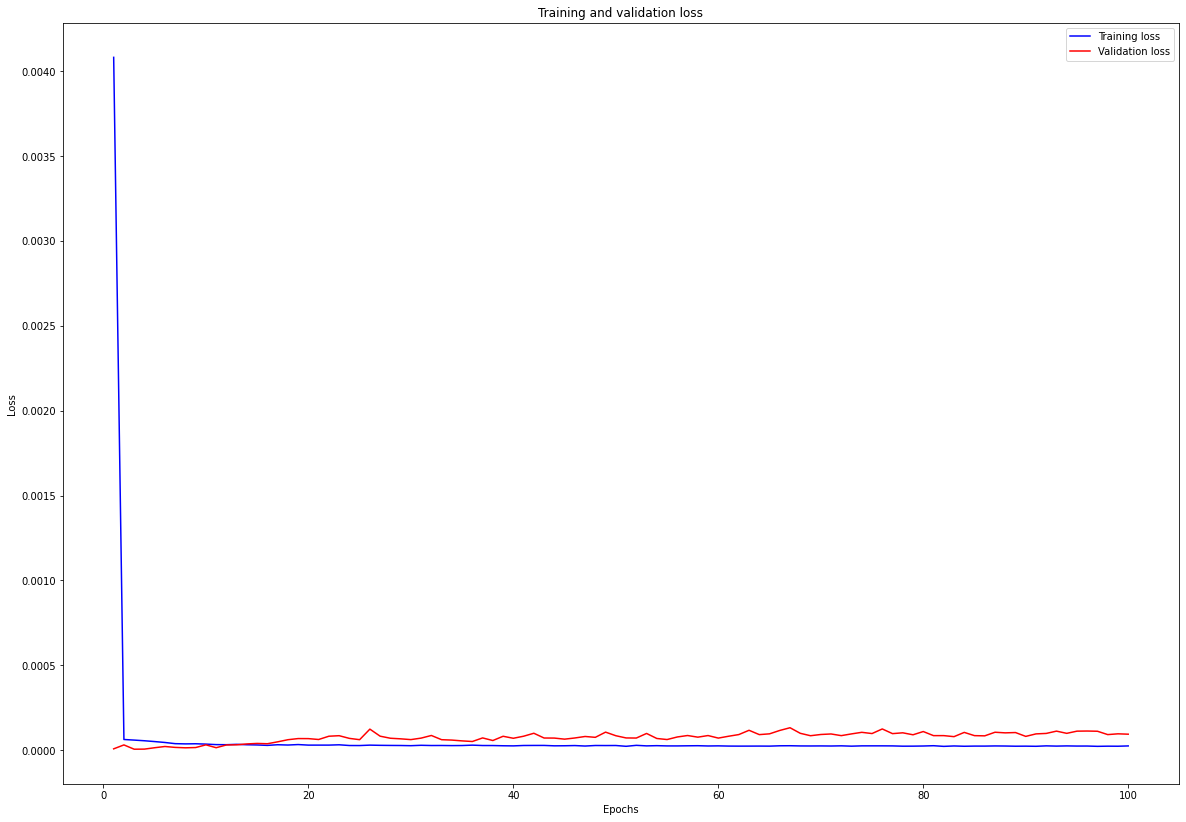

In [50]:
#plot the training and validation accuracy and loss at each epoch
loss = history_convLSTM.history['loss']
val_loss = history_convLSTM.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

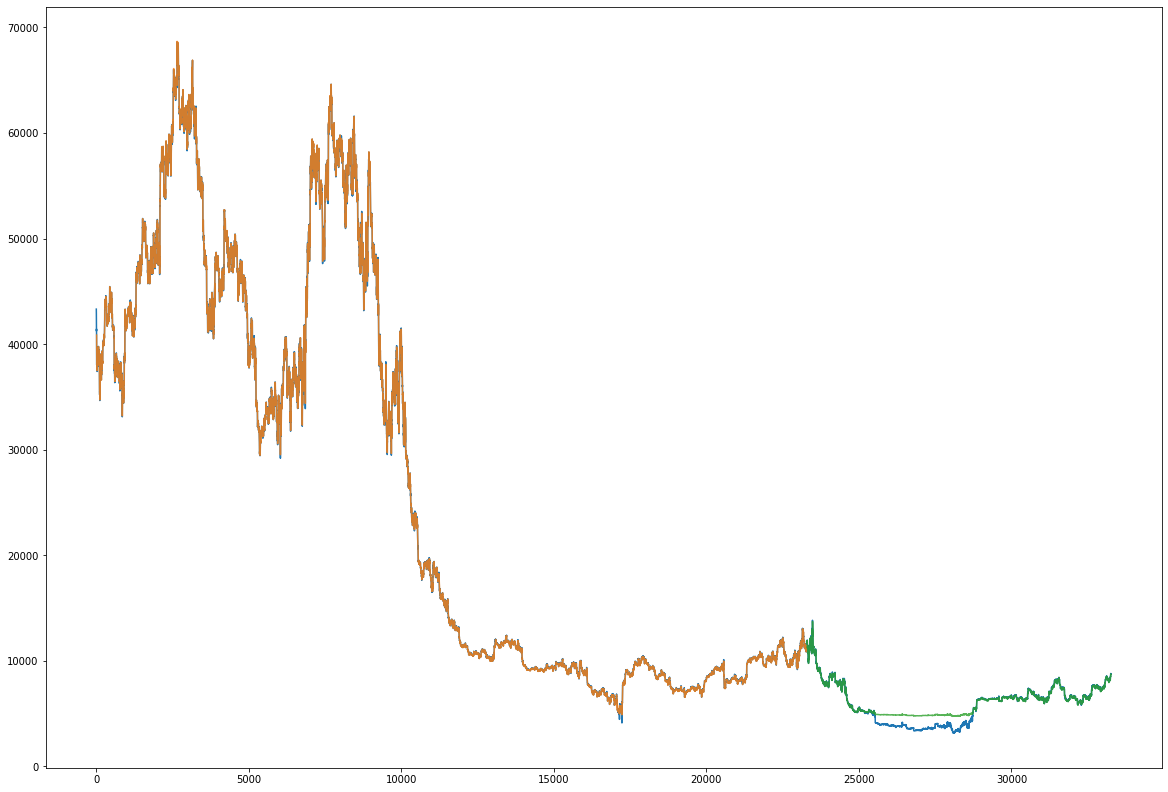

In [51]:
# plot baseline and predictions
plt.rcParams["figure.figsize"] = (20,14)
plt.plot(scaler.inverse_transform(btc))
plt.plot(trainPredictPlot, alpha = 0.8)
plt.plot(testPredictPlot, alpha = 0.8)
plt.show()

In [ ]:
!pip install altair

In [ ]:
import altair as alt